In [ ]:
#1.SpamAssassin Email – Random Forest + XGBoost

#Import Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# loading dataset
df = pd.read_csv("spam_assassin.csv")

df.head()


,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0


In [3]:
# Train–Test Split

X = df["text"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
#TF-IDF Vectorization

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [5]:
#Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression F1-score:", f1_lr)


Logistic Regression F1-score: 0.9578231292517007


In [6]:
#Random Forest Classifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest F1-score:", f1_rf)
print(classification_report(y_test, y_pred_rf))


Random Forest F1-score: 0.9679144385026738
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       781
           1       0.98      0.96      0.97       379

    accuracy                           0.98      1160
   macro avg       0.98      0.97      0.98      1160
weighted avg       0.98      0.98      0.98      1160



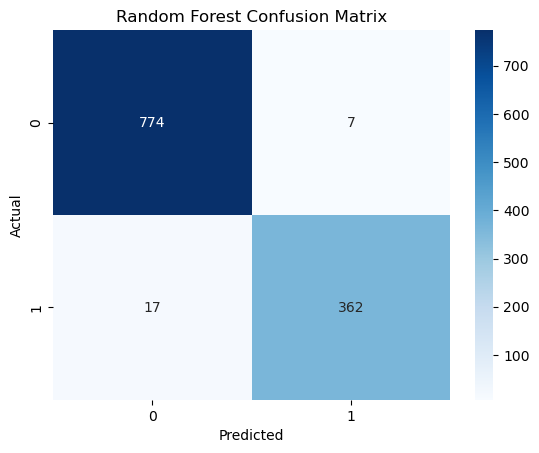

In [7]:
#Confusion Matrix:

cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()



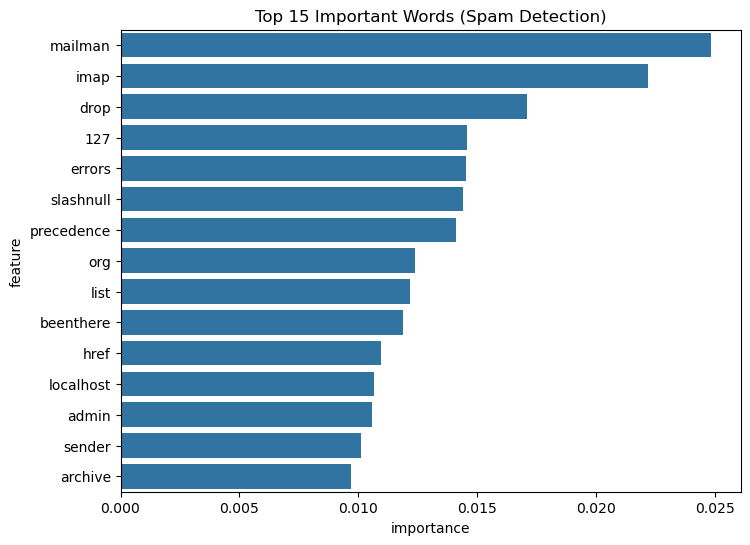

In [7]:
#Feature Importance:

feature_names = vectorizer.get_feature_names_out()
importances = rf.feature_importances_

feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_df)
plt.title("Top 15 Important Words (Spam Detection)")
plt.show()


In [8]:
#XGBoost Classifier:

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)

f1_xgb = f1_score(y_test, y_pred_xgb)
print("XGBoost F1-score:", f1_xgb)



XGBoost F1-score: 0.9853917662682603


In [15]:
#2.Ames Housing – Random Forest + XGBoost

#libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [17]:
#load dataset
df = pd.read_csv("AmesHousing.csv")
print("Dataset Shape:", df.shape)

df.head()


Dataset Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [18]:
#Select Features & Target:

X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

categorical_cols = X.select_dtypes(include="object").columns
numerical_cols = X.select_dtypes(exclude="object").columns

print("Categorical features:", len(categorical_cols))
print("Numerical features:", len(numerical_cols))


Categorical features: 43
Numerical features: 38


In [ ]:
#Preprocessing Pipeline:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


In [20]:
#Train–Test Split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#Linear Regression:
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))


Linear Regression R²: 0.736544589057443


In [22]:
#Random Forest :
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


Random Forest R²: 0.9096026612340875
Random Forest RMSE: 26921.459774354917


In [23]:
#Model Comparison :
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R2_Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf)
    ]
})

results


,Model,R2_Score
0,Linear Regression,0.736545
1,Random Forest,0.909603


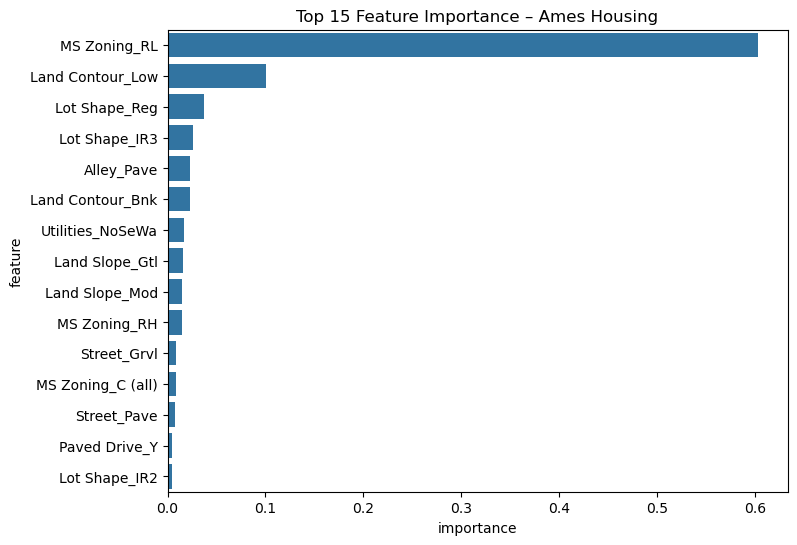

In [24]:
#Feature Importance :
rf = rf_model.named_steps["model"]
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]

feature_names = np.concatenate([
    ohe.get_feature_names_out(categorical_cols),
    numerical_cols
])

importances = rf.feature_importances_

feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x="importance", y="feature", data=feat_df)
plt.title("Top 15 Feature Importance – Ames Housing")
plt.show()


In [25]:
#XGBoost Regressor :
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


XGBoost R²: 0.9355345964431763


In [26]:
#final results :

final_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "R2_Score": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb)
    ]
})

final_results


,Model,R2_Score
0,Linear Regression,0.736545
1,Random Forest,0.909603
2,XGBoost,0.935535
